$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\mP}{{\bf P}}
\newcommand{\mU}{{\bf U}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\vb}{{\bf b}}
\newcommand{\vz}{{\bf z}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\mb}{{\bf B}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$

In [1]:
include("fanote_init.jl")

# Chapter 2: Finding the Newton Step with Gaussian Elimination

## Contents for Chapter 2

[Section 2.1: Direct Methods for Solving Linear Equations](#Section-2.1:-Direct-Methods-for-Solving-Linear-Equations)

[Section 2.2: The Newton-Armijo Iteration](#Section-2.2:-The-Newton-Armijo-Iteration)

[Section 2.3: Computing a Finite Difference Jacobian](#Section-2.3:-Computing-a-Finite-Difference-Jacobian)

[Section 2.4: The Chord and Shamanskii Methods](#Section-2.4:-The-Chord-and-Shamanskii-Methods)

[Section 2.5: What Can Go Wrong?](#Section-2.5:-What-Can-Go-Wrong?)

[Section 2.6: Precomputed and Preallocated Data](#Section-2.6:-Precomputed-and-Preallocated-Data)

[Section 2.7: Four Nonlinear Systems](#Section-2.7:-Four-Nonlinear-Systems)



Direct methods for solving the equation for the Newton step
are a good idea if

- the Jacobian can be computed and __stored__ efficiently and
- the cost of the factorization of the Jacobian is not excessive or
- iterative methods do not converge for your problem.


Even when direct methods work well,
Jacobian factorization and storage of that
factorization may be more expensive than a solution by iteration.
However, direct methods are more robust than iterative methods and
do not require your worrying about
the possible convergence failure of an iterative method or
preconditioning.

If the linear equation for the Newton step is solved exactly
and the Jacobian is computed and factored with each nonlinear
iteration (i.e., $\eta = 0$ in Algorithm __nsolg__), one should
expect to see q-quadratic convergence until finite-precision
effects produce stagnation (as predicted in __Theorem 1.2__.
One can, of course, approximate the Jacobian or evaluate it only
a few times during the nonlinear iteration, exchanging an increase
in the number of nonlinear iterations for a dramatic reduction in
the cost of the computation of the steps.

In many cases, as we pointed out in __Chapter 1__,
one can store and factor $\mf'$ in reduced precision
with no loss in the quality of the solution. If, as we
do in this book, one computes $\mf$ in double precision (Float64), storing
and factoring $\mf'$ in single precision (Float32) cuts the linear algebra
cost in half. Our solvers enable you to do this with ease by allocating
the storage for $\mf'$ in single precision. We have a detailed example
of this in the notebook.

The Julia codes for the examples in this chapter are in the
[src/Chapter2](src/Chapter2) directory for the notebook. 



## Section 2.1: Direct Methods for Solving Linear Equations

In this chapter we solve the equation for the Newton step with
Gaussian elimination. As is standard in numerical linear algebra
(see \cite{golub,trefbau,demmel,stewart}, for example),
we distinguish between the factorization and the solve.
The typical implementation of Gaussian elimination, called
an __LU factorization__,
factors the coefficient matrix
$\ma$ into a product of a permutation matrix and
lower and upper triangular factors:
$$
\ma = \mP \ml \mU.
$$
The factorization may be simpler and less costly if the matrix
has an advantageous structure (sparsity, symmetry, positivity, ...)
<cite data-cite="golub"><a href="siamfa.html#golub">(GV96)</cite>,
<cite data-cite="stewart"><a href="siamfa.html#stewart">(Ste73)</cite>,
<cite data-cite="trefbau"><a href="siamfa.html#trefbau">(TB96)</cite>,
<cite data-cite="demmel"><a href="siamfa.html#demmel">(Dem97)</cite>,
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>,
<cite data-cite="lapack"><a href="siamfa.html#lapack">(ABB<sup>+</sup>92)</cite>.

The permutation matrix reflects row interchanges that are done during
the factorization to improve stability. In Julia the best way to
do this is to factor $\ma$ __in-place__. This means that $\ml$
and $\mU$ are stored by __overwriting__ $\ma$ and the permutation is
recorded in an integer vector. Julia's convention for a function that
overwrites it's input is to put a $!$ after the name of the function.
So you invoke the LU factorization with

```Julia
B = lu!(A).
```

There is a subtle point here that really matters for Newton's method.
While $\mb$ and $\ma$ share storage, they are different data structures.
One can, for example, update $\ma$ as a matrix, as one would do in a
nonlinear solver if $\ma$ is an approximation of the Jacobian. One cannot
do that if one makes the call as

```Julia
A = lu!(A),
```
because then you have changed the data type of $\ma$.

For example, let
$$
\ma = \left(
\begin{array}{ccc}
4 & 6 & 6 \\ 2 & 2 & 3 \\ 7 & 8 & 10
\end{array}
\right)\!.
$$
The LU factorization
```Julia
[l,u]=lu(A)
```
returned by the Julia command is
```Julia
julia> B=lu!(A)
LU{Float64,Array{Float64,2}}
L factor:
3×3 Array{Float64,2}:
 1.00000e+00   0.00000e+00  0.00000e+00
 5.71429e-01   1.00000e+00  0.00000e+00
 2.85714e-01  -2.00000e-01  1.00000e+00
U factor:
3×3 Array{Float64,2}:
 7.00000e+00  8.00000e+00  1.00000e+01
 0.00000e+00  1.42857e+00  2.85714e-01
 0.00000e+00  0.00000e+00  2.00000e-01
```

The permutation is elsewhere in $B$. To see this
```Julia
julia> B.L * B.U
3×3 Array{Float64,2}:
 7.00000e+00  8.00000e+00  1.00000e+01
 4.00000e+00  6.00000e+00  6.00000e+00
 2.00000e+00  2.00000e+00  3.00000e+00
```
Indicating that $\ml \mU = \mP^T \ma$. The permutation vector is
```Julia
julia> B.p
3-element Array{Int64,1}:
 3
 1
 2
```

We use the output of ```lu!``` with the standard backslash notation. So
to solve $\ma \vx = \vb$ one would do this.
```
julia> B=lu!(A);
julia> s=B\b;
```
In the REPL, the semicolon suppresses output, just as it does in Matlab.

We will ignore the permutation for the remainder of this chapter, but
the reader should remember that it is important. Most
linear algebra software
<cite data-cite="lapack"><a href="siamfa.html#lapack">(ABB<sup>+</sup>92)</cite>,
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>
manages the permutation for you in some way.
    
The cost of an LU factorization of an $N \times N$ matrix
is $N^3/3 + O(N^2)$ flops, where, following
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>,
we define a flop as an add, a multiply, and some address computations.
The factorization is the most expensive part of the solution.

Following the factorization, one can solve the linear system as we
described above. Internally that means to solve
$\ma \vs = \vb$ by solving the two triangular systems $\ml \vz = \vb$ and
$\mU \vs = \vz$. The cost of the two triangular solves is $N^2 + O(N)$
flops.

One final point, which we will return to soon, is that using ```lu!```
rather than ```lu``` is very important. The ```lu``` function performs
the same factorization, but allocates new storage for the results rather
than overwriting the original matrix. The penalty for allocating memory
in Julia is severe and one must take care to avoid it.


## Section 2.2: The Newton-Armijo Iteration

Algorithm __newton__ is an implementation of Newton's method that
uses Gaussian elimination to compute the Newton
step. The significant contributors to the computational cost
are the computation and LU factorization of the Jacobian.
The factorization can fail if, for example,
$\mf'$ is singular or highly ill-conditioned.

![Alg2.1](Images/Alg2dot1.png)

The Newton-like solvers in this chapter all follow this paradigm. The
bulk of the work and the difference in the solvers are in the
evaluation of the (approximate) Jacobian and the linear solve. If
one uses direct methods, one can think of the evaluation and factor

__Compute $\mf'(\vx)$; factor $\mf'(\vx) = \ml \mU$.__

as a single operation that prepares a linear operator to compute
the step.



## Section 2.3: Computing a Finite Difference Jacobian

The effort in the computation of the Jacobian
can be substantial. In some cases one can compute the function
and the Jacobian at the same time and the Jacobian costs little
more (see the example in [Section 2.7.2](#Section-2.7.2:-Chandrasekhar-H-Equation);
also see
[Section 2.5.2](#Section-2.5.2:-Finite-Difference-Jacobian-Error)) than the evaluation
of the function. However, if only function evaluations are available, then
approximating the Jacobian
by differences is one option (but see the project on automatic
differentiation at the end of this chapter).
As we said in
__Chapter 1__, this usually causes no problems in the
nonlinear iteration and
a forward difference approximation is probably sufficient. One
computes the forward difference approximation $(\nabla_h F)(x)$
to the Jacobian by columns. The $j$th column is

\begin{equation}
(\nabla_h \mf)(\vx)_j = \left\{
\begin{array}{ll}
\dfrac{\mf(\vx + h \ve_j ) - \mf(\vx)}{h}, & x_j \ne 0,\\
\\
\dfrac{\mf(h \ve_j ) - \mf(\vx)}{h}, & x_j = 0.
\end{array}
\right.
\end{equation}

In the equation, $\ve_j$ is the unit vector in the $j$th coordinate
direction.  The difference increment $h$ should be no smaller than
the square root of the inaccuracy in $\mf$.
Each column of $\nabla_h \mf$ requires one
new function evaluation and, therefore, a finite difference Jacobian
costs $N$ function evaluations.

The difference increment in the equation for a finite difference Jacobian
should be __scaled___. Rather
than simply perturb $\vx$ by a difference increment $h$ times $\ve_j$, where $h$ is
roughly the square root of the error in $F$, we
multiply the perturbation by $\| \vx \|$ 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>.
Hence, if
the error in $\mf$ is $\epsilon$, we use a difference increment
of $h = \| \vx \| dx$ where $dx \approx \sqrt{\epsilon}$
You can adjust this in our solvers. The default
in the solvers for this book is $dx = 10^{-7}$.

## Section 2.4: The Chord and Shamanskii Methods

If the computational cost of a forward difference Jacobian is high
($\mf$ is expensive and/or $N$ is large) and
if an analytic Jacobian is not available, it is wise to amortize this
cost over several nonlinear iterations. The {\bf chord method}
 from __Section 1.3__ does exactly that.
Recall that the chord method differs from Newton's method in that
the evaluation and factorization of the Jacobian are done only once
for $\mf'(\vx_0)$.  The advantages of the chord
method increase as $N$ increases, since both the $N$ function evaluations
and the $O(N^3)$ work (in the dense matrix case)
in the matrix factorization are done only once. So, while the convergence
is q-linear and more nonlinear iterations will be needed than for
Newton's method, the overall cost of the solve will usually be much less.
The chord method is the solver of choice in many codes for stiff
initial value problems
<cite data-cite="lsode"><a href="siamfa.html#lsode">(RH93)</cite>,
<cite data-cite="slc"><a href="siamfa.html#slc">(BCP96)</cite>,
<cite data-cite="lindauri"><a href="siamfa.html#lindauri">(AP98)</cite>, 
where the Jacobian may not
be updated for several time steps.

Algorithms __chord__ and __shamanskii__ are
special cases of __nsolg__. Global convergence
problems have been ignored, so the step and the direction are the same,
and the computation of the step is based on an LU factorization of
$\mf'(\vx)$ at an iterate that is generally not the current one.
    
![Alg2.2](Images/Alg2dot2.png)
    
A middle ground is the __Shamanskii method__
(see __Section 1.3__)
<cite data-cite="sham"><a href="siamfa.html#sham">(Sha67)</cite>.
Here the Jacobian factorization and matrix
function evaluation are done after every $m$ computations of the
step.
    
![Alg2.3](Images/Alg2dot3.png)
    
If one counts as a complete iteration the full $m$ steps
between Jacobian computations and factorizations, the Shamanskii
method converges q-superlinearly with __q-order__ 
$m+1$; i.e.,
$$
\| \vx_{n+1} - \vx^* \| \le K \| \vx_{n} - \vx^* \|^{m+1}
$$
for some $K > 0$.
Newton's method, of course, is the $m=1$ case. The default in
__nsol.jl__ is $m=5$ for systems of equations. This is different
from that in __nsolsc.jl__, where we use $m=1$ for scalar equations.
We will look into this and other ways to improve the performance of
Newton's method in __Section 2.8__.

## Section 2.5: What Can Go Wrong?

The list in __Section 1.9__ is complete, but it's worth
thinking about a few specific problems that can arise when you
compute the Newton step with a direct method. The major point
to remember is that, if you use an approximation to the Jacobian,
then the line search can fail. You should think of the chord
and Shamanskii methods as local algorithms, to which a code will
switch after a Newton-Armijo iteration has resolved any global
convergence problems. With the exception of the chore method, where
we leave you on your own,
our solvers update the Jacobian if the line
search reduces the steplength on the previous iteration.

### Section 2.5.1: Poor Jacobians

The chord method and other methods that amortize factorizations
over many nonlinear iterations perform well because factorizations
are done infrequently. This means that the Jacobians will be
inaccurate, but, if the initial iterate is good, the Jacobians
will be accurate enough for the overall performance to be far
better than a Newton iteration.
However, if your initial iterate is far from a solution, this
inaccuracy can cause a __line search to fail__. Even if
the initial iterate is acceptable, the convergence may be
slower than you'd like. Our code __nsol.jl__
(see __Section 2.8__) watches for these problems
and updates the Jacobian if either the line search fails or
the rate of reduction in the nonlinear residual is too slow.

### Section 2.5.2: Finite Difference Jacobian Error

The choice of finite difference increment $h$ deserves some thought.
You were warned in __Sections 1.9.3__ and __1.9.4__
that the difference increment in a
forward difference approximation to a Jacobian or a Jacobian-vector
product should be a bit more than the square root of the error in the
function. Most codes, including ours, assume that the error in the
function is on the order of floating point roundoff. If that
assumption is not valid for your problem, the difference increment
must be adjusted to reflect that. Check that you have scaled the
difference increment to reflect the size of $\vx$, as we did in 
[Section 2.3](#Section-2.3:-Computing-a-Finite-Difference-Jacobian).
If the components of $\vx$ differ dramatically in size,
consider a change of independent variables to rescale them.

One might think that centered differences would be better, but
that would be wrong <cite data-cite="nixon"><a href="siamfa.html#nixon">(Nix72)</cite>.
The cost of a centered
difference Jacobian is very high and there is no benefit for the
nonlinear iteration.
Another approach
<cite data-cite="lynessmoler"><a href="siamfa.html#lynessmoler">(LM67)</cite>,
<cite data-cite="sqtrapp"><a href="siamfa.html#sqtrapp">(ST98)</cite>,
uses complex arithmetic to get higher order accuracy.
If $\mf$ is smooth and can be evaluated
for complex arguments, then you can get a second-order
accurate directional derivative with a single function evaluation by using
the formula

$$
Im (\mf(\vx + i h \vu))/h = \mf'(\vx)\vu + O(h^2).
$$

One should use this formula with some care if there are
errors in $\mf$ and, of course, one should scale $h$.
    
One other approach to more accurate derivatives is automatic
differentiation <cite data-cite="grautodiff"><a href="siamfa.html#grautodiff">(Gri00)</cite>. 
Automatic differentiation
software takes as its input a code for $\mf$ and produces a code
for $\mf$ and $\mf'$. The derivatives are exact, but the codes
are usually less efficient and larger than a hand-coded Jacobian
program would be. Automatic differentiation software for C, C++,
and FORTRAN is available from the US DOE Laboratories
\cite{anlautodiff,trilinos}. There are also
many packages in Julia, for example
__Zygote.jl__, <cite data-cite="zygote"><a href="siamfa.html#zygote">(CoRR)</cite>,
__ForwardDiff.jl__, <cite data-cite="forwarddiff"><a href="siamfa.html#forwarddiff">(RPL16)</cite>,
and __ReverseDiff.jl__, <cite data-cite="reverseDiff"><a href="siamfa.html#reverseDiff">(Rev20)</cite>.
Automatic differention is far beyond the scope of this book, but
the reader is welcome to investigate it and we have a project
about that in __Section 2.9__.




### Section 2.5.3: Sparse Jacobians

If $\mf'$ is sparse, you may have the option to compute a sparse
factorization without pivoting. If, for example,
$\mf'$ is symmetric and positive definite, this is the way to
proceed. For general $\mf'$, however, pivoting can be essential
for a factorization to produce useful solutions. For sparse
problems, the cost of pivoting can be large and it is tempting
to avoid it. If line search fails and you have disabled pivoting
in your sparse factorization, it's probably a good idea to
re-enable it and find a way to deal with the fill-in.

The cost estimates for a difference Jacobian
change if $\mf'$ is sparse, as does the cost of
the factorization.
In the sparse case one can compute several columns
of the Jacobian with a single new function evaluation. The methods
for doing this for general sparsity patterns
<cite data-cite="colmore"><a href="siamfa.html#colmore">(CM83)</cite>,
<cite data-cite="curtispr"><a href="siamfa.html#curtisor">(CPR74)</cite>.
are too complex for this book. The
__SparseDiffTools.jl__ <cite data-cite="sparsediff"><a href="siamfa.html#sparsediff">(RMGH20)</cite>
package in Julia is a way to incorporate
sparse differeces into your Jacobian evaluation function.

Even thought sparse differencing can be done efficiently, sparse
matrix factorization is still problematic. The factors are typically
more dense than the orignal matrix, a phenomenon called
__fill-in__. Hence a sparse LU factorization cannot be expected
to overwrite the original matrix and to use little new storage beyond
that. One can do a symbolic factorization
<cite data-cite="davisbook"><a href="siamfa.html#davisbook">(Dav06)</cite>
and figure
out how much storage is needed and then preallocate that storage.
We challange the reader to do that in one of the projects at the
end of this chapter.
    
Our __nsol.jl__ code does a sparse LU by default if $\mf'$ is sparse
and pays the price for the memory allocation. One cannot
expect to overwrite the storage for $\mf'$ with the factors and must use
the output of a symbolic factorization to avoid allocation storage many times.
Banded matrices 
\cite{lapack} are an exception and we will look at
an example in [Section 2.7.3](#Section-2.7.3:-A-Two-Point-Boundary-Value-Problem).

Finally, the general sparse solvers in Julia are based on the SparseSuite
codes <cite data-cite="davisbook"><a href="siamfa.html#davisbook">(Dav06)</cite>
which require double precision. Hence one
cannot do the linear algebra in single precision in this case.
Some matrices with special structure, such as banded matrices, do allow
this.


## Section 2.6: Precomputed and Preallocated Data

Many of the examples in this book depend on data that one should
compute and store only once.  Our solvers use the kwarg ```pdata```
for this and allow you to pass that to the function, the Jacobian,
and the Jacobian (and preconditioner)-vector products.

More importantly, allocation of data is expensive in Julia and
our codes use in-place solvers like __lu!__ when possible. The
solvers also require that you preallocate space for the Jacobian and
residual. Doing this is easy and the examples will illustrate the
process.

## Section 2.7: Four Nonlinear Systems

In this section we show how to use __nsol.jl__ for four problems.
The computations in this section use very few of the options in the
solver and show how to use __nsol.jl__ in the most simple manner.
In __Section 2.8__ we will explain the options for
__nsol.jl__ in detail and revisit the examples in this section.
In this section we will use Newton's method (```sham=1```) for the examples. The default
for systems is ```sham=5``` and we will show why that is a good idea
in __Section 2.8__. The author of this book also likes
```sham=Inf```, which differs from the chord method in that the Jacobian
is updated if the reduction in the residual norm is larger than
```resdec``` (default $= .1$). The reader should look at
<cite data-cite="brent"><a href="siamfa.html#brent">(Bre73)</cite>
for one vintage
view of how often one should update the Jacobian.

The interface to __nsol.jl__ is very similar to that of the
scalar code __nsolsc.jl__ from the previous chapter. The most
sigificant differences are in the way you must manage storage.
You must allocate storage for your function and Jacobian in the
calling program and the Julia functions you write for evaluate
functions and Jacobians will overwrite that storage.

We will call __nsol.jl__ with mostly the default options.
```Julia
nsolout=nsol(F!, x0, FS, FPS, J!; sham =1)
```

Here ```nsolout``` is the output data structure, which, as we said above
is very similar to the one for our scalar codes. $x_0$ is the initial
iterate. The new thing is the preallocated storage for the function
__FS__
and Jacobian __FPS__. __F!__ is the function for evaluation the residual
and {\bf J!} the function for evaluating the Jacobian. The sytax for
__F!__ is
```Julia
FS=F!(FS,x)
```
__F!__ will return __FS = F(x)__, overwriting the data stored in __FS__. Similarly one computes
the Jacobian with
```Julia
FPS=J!(FV,FPS,x)
```
to compute __FPS = F'(x)__. Note that __FS__ must also be
an argument for the Jacobian evaluation function __J!__. The reason for
this, and the reason that __J!__ is last in the argument list, is
that __J!__ will default to a finite difference Jacobian evaluation if
left out of the call to __nsol.jl__. So
```Julia
nsolout=nsol(F!, x0, FS, FPS; sham=1)
```
will solve $\mf(\vx) = 0$ with Newton's method and a finite-difference
Jacobian.


### Section 2.7.1: A Simple Two-Dimensional Example

This example is from <cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>.
Here $N=2$ and

\begin{equation}
\mf(\vx) = \left( \begin{array}{c}
x_1^2 + x_2^2 - 2\\ \exp(x_1 - 1) + x_2^2 - 2
\end{array}
\right)\!
\end{equation}

This function is simple enough for us to put the 
Julia code from __SIAMFANLEquations.jl/src/TestProblems/Chapter2/simple!.jl__
that computes the function here.

```Julia
function simple!(FV,x)
   FV[1]=x[1]*x[1] + x[2]*x[2] -2.0;
   FV[2]=exp(x[1]-1) + x[2]*x[2] - 2.0;
end
```



In the experiment we report in this section take the defaults
$\tau_a = 10^{-12}$ and
$\tau_r = 10^{-6}$ and use a finite-difference Jacobian.
We investigated two initial iterates.
For $\vx_0 = (2,0.5)^T$, the step length was reduced
twice on the first iteration. Full steps were taken after that.
This is an interesting example because the iteration can stagnate
at a point where $\mf'(\vx)$ is singular. If $\vx_0 = (3,5)^T$,
the line search will fail and the stagnation point will be
near the $x_1$-axis, where the Jacobian is singular.

The code for the experiment is included in the notebook in
__NotebookSIAMFANL/src/Chapter2/TwoDexample.jl__
We will list the part of __TwoDexample.jl__ that calls the solver
and let the interested reader look at the source for the details of
the plotting. Note how I've allocated the storage for the residual and the Jacobian.

```Julia
function TwoDexample()
  x0a=[2, .5];
  x0b=[3, 5];
# Allocate some room for the resdiual and Jacobian
  FS=zeros(2,);
  FPS=zeros(2,2);
  nouta=nsol(simple!, x0a, FS, FPS; sham=1, keepsolhist=true);
  xa=nouta.solhist[1,:];
  ya=nouta.solhist[2,:];
  noutb=nsol(simple!, x0b, FS, FPS; sham=1, keepsolhist=true);
  xb=noutb.solhist[1,:];
  yb=noutb.solhist[2,:];
#
# Some plotting commands you may not want to look at are here.
#
end
```

Note that we ask for the solution history in each call to
__nsol.jl__ because we plot that history in the figure. In Figure 2.1
we plot the iteration history for
both choices of initial iterate on a contour plot of $\| \mf \|$.
The iteration that stagnates converges, but not to a root!
Line search codes that terminate when the step is small should
also check that the solution is an approximate root, perhaps
by evaluating $\mf$ (see __Section 1.9.2__).


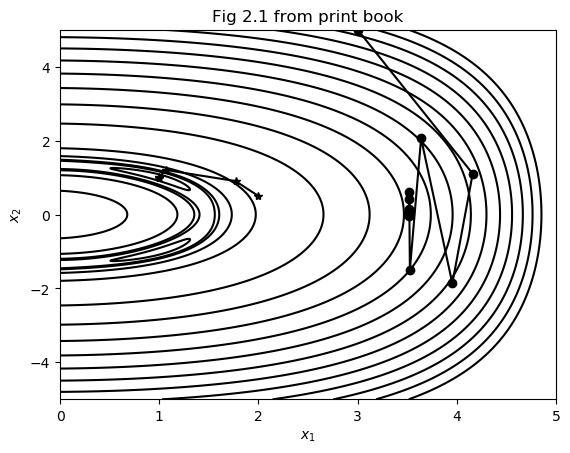

The line search failed at iteration 15
Termination with failure
Current values: maxit  =  20, armmax = 10
Give the history array a look to see what's happening.
  


In [2]:
TwoDexample();

### Section 2.7.2: Chandrasekhar H-Equation

The Chandrasekhar H-equation 
<cite data-cite="chand"><a href="siamfa.html#chand">(Cha60)</cite>,
<cite data-cite="busb"><a href="siamfa.html#busb">(Bus60)</cite> is
    
\begin{equation}
F(H)(\mu) =
H(\mu) - \left(1 - \dfrac{c}{2} \int_0^1
\dfrac{\mu H(\nu) \, d\nu}{\mu + \nu} \right)^{-1}
= 0.
\end{equation}
    
This equation arises in radiative transfer theory.

This equation has a well-understood dependence on the parameter $c$
<cite data-cite="twm68"><a href="siamfa.html#twm68">(Mul68)</cite>,
<cite data-cite="ctk:n1"><a href="siamfa.html#ctk:n1">(DK80)</cite>.
The equation has unique solutions at $c=0$
and $c=1$ and two solutions for $0 < c < 1$. There is a simple fold
singularity \cite{herb} at $c=1$. Only one 
<cite data-cite="chand"><a href="siamfa.html#chand">(Cha60)</cite>,
<cite data-cite="busb"><a href="siamfa.html#busb">(Bus60)</cite>,
of the two solutions for $0 < c < 1$ is of physical interest
and that is the one easiest to find numerically. One must perform
a continuation computation to find the other one.
    
The structure of the singularity is preserved if one discretizes
the integral with any quadrature rule with positive weights
that integrates constants exactly. This fact enables one to readily
understand the behavior of nonlinear solvers.

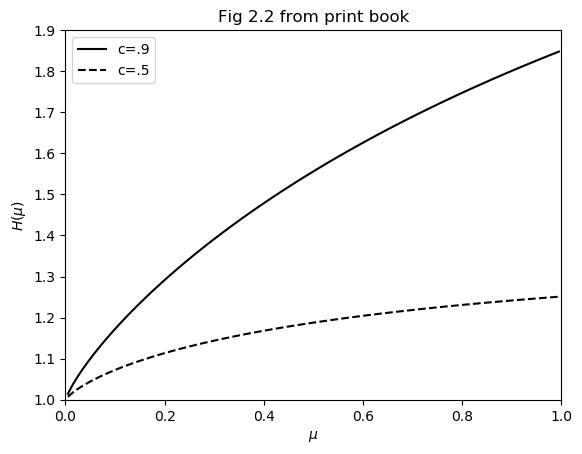

In [3]:
HeqSolutions();

### Section 2.7.3: A Two Point Boundary Value Problem

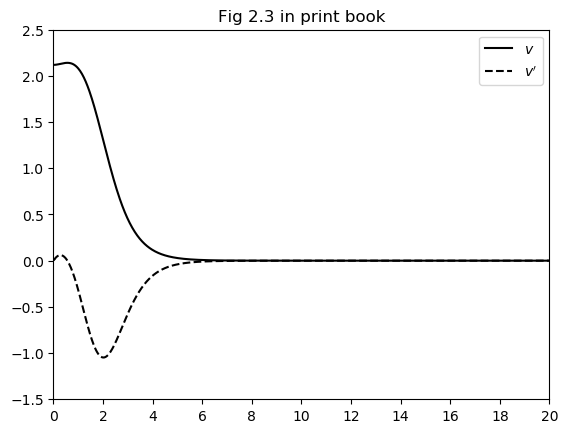

In [4]:
BVPsolution(801, Float64);

### Section 2.7.4: Stiff Initial Value Problems and the Buckling Beam

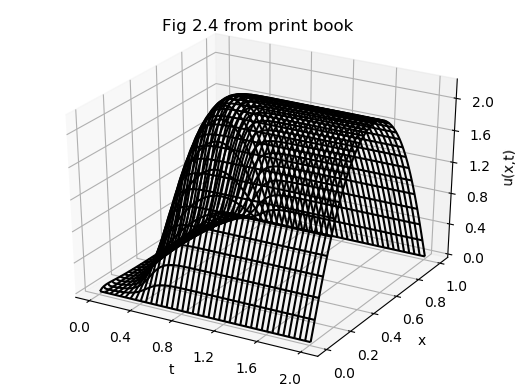

In [5]:
beamtimedep();

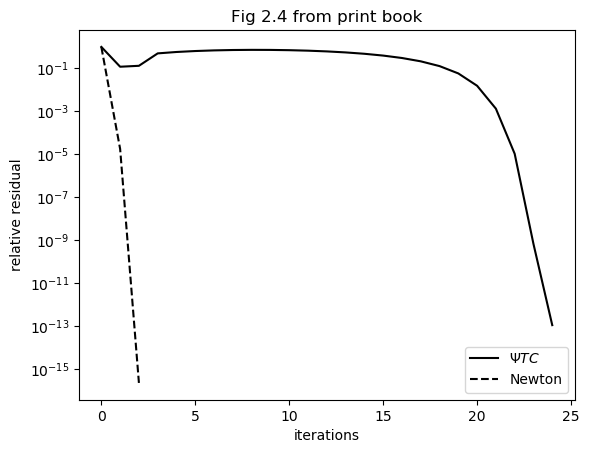

In [6]:
beamptc();

## Next notebook = [Section 2.8: Solvers for Chapter 2](SIAMFANLCh2s.ipynb)